## Settings

In [ ]:
# Files
GDRIVE_DIR = r'/content/drive/MyDrive/DS/20230314_ke-intern-test/'

DATASET_DIR = GDRIVE_DIR + 'dataset/'

DF_TRAIN = DATASET_DIR + 'train.parquet'
DF_TEST = DATASET_DIR + 'test.parquet'

CATEGORIES_TSV = GDRIVE_DIR + 'categories.tsv'

# Model
BERT_MODEL_NAME = 'DeepPavlov/rubert-base-cased-sentence'
INPUT_TOKENS_LIMIT = 300  # max:512

# Reproducibility
SEED = 1

# Init

## Downloads

In [ ]:
!pip install -q transformers

## Imports

In [ ]:
import json
import re

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from transformers import BertTokenizerFast

## Definitions

In [ ]:
#@title  { form-width: "1px", display-mode: "form" }
#@markdown ```python
#@markdown def count_params(model)
#@markdown def remove_html_tags(text)
#@markdown def charact_to_text(charact_dict)
#@markdown def fields_to_text(fields_dict)
#@markdown def get_attention_mask(seq_lengths, max_len)
#@markdown def truncate_and_pad_input_ids(input_ids, pad_token_id, max_len=None)
#@markdown class LabelEncoder(categories_tsv_path: str)
#@markdown ```


def count_params(model):
    return sum(w.numel() for w in model.parameters())


RE_HTML_TAG = re.compile(r'<[^>]*>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
RE_SPACES = re.compile(r'  +')

def remove_html_tags(text):
    text = RE_HTML_TAG.sub(' ', text).strip()
    text = RE_SPACES.sub(' ', text)
    return text


def charact_to_text(charact_dict):
    """
    In: {'Размер одежды': ['XXXL', 'L', 'XXL', 'XL'], 'Цвет': ['Белый']}
    Out: 'Размер одежды: XXXL, L, XXL, XL\nЦвет: Белый'
    """
    rows = []
    for key, value in charact_dict.items():
        if type(value) is not list:
            raise ValueError(f'characteristics unknown format:\n{charact_dict}')
        values_str = ', '.join(set(value))
        rows.append(f'{key}: {values_str}')
    return '\n'.join(rows)


EXPECTED_FIELD_NAMES = {
    'attributes',
    'custom_characteristics',
    'defined_characteristics',
    'description',
    'filters',
    'title'}

def fields_to_text(fields_dict):
    unknown_fields = set(fields_dict) - EXPECTED_FIELD_NAMES
    if unknown_fields:
        raise ValueError(f'Unexpected field names: {unknown_fields}')
    
    rows = []
    if 'title' in fields_dict:
        rows.append(fields_dict['title'])
    if 'description' in fields_dict:
        descr = remove_html_tags(fields_dict['description'])
        if descr:
            rows.append(descr)
    rows.extend(fields_dict['attributes'])
    for charact_field in ['custom_characteristics', 'defined_characteristics', 'filters']:
        charact_text = charact_to_text(fields_dict[charact_field])
        if charact_text:
            rows.append(charact_to_text(fields_dict[charact_field]))
    text = '\n'.join(rows)
    if len(text) > 2048:
        return ' '.join([text[:1024], text[-1023:]])
    else:
        return text


def get_attention_mask(seq_lengths, max_len):
    """
    >>> make_attention_mask([3, 1, 2], 6)
    array([[1, 1, 1, 0, 0, 0],
           [1, 0, 0, 0, 0, 0],
           [1, 1, 0, 0, 0, 0]], dtype=uint8)
    """
    pos = np.arange(0, max_len, dtype=np.uint32).reshape(1, -1)  # row
    range = np.asarray(seq_lengths).reshape(-1, 1)               # col
    return (pos < range).astype(np.uint8)  # broadcast (len(col), len(row))


def truncate_and_pad_input_ids(input_ids, pad_token_id, max_len=None):
    """
    input_ids : list of lists or 2d array
        `input_ids` from the tokenizer.
    pad_token_id : int
        Specific to particular language model. Usually 0 or 1. Can be found
        using `transformers.AutoTokenizer(MODEL_NAME).pad_token_id`.
    max_len : None or int
        If None, the target lenght will be the length of the longest sequence.

    Example:
    >>> truncate_and_pad_input_ids([[1,2,3,4,5], [1,2,3], [1,2,3,4,5,6,7,8]], 4)
    array([[1, 2, 4, 5],
           [1, 2, 3, 0],
           [1, 2, 7, 8]], dtype=uint32)}
    """
    assert max_len is None or max_len > 0

    length = list(map(len, input_ids))

    target_len = max(length) if max_len is None else max_len
    begin_len = target_len // 2
    end_len = target_len - begin_len

    final_input_ids = np.full((len(input_ids), target_len),
        fill_value=pad_token_id, dtype=np.uint32)

    for i, ids in enumerate(input_ids):
        ids = list(ids)
        if len(ids) > target_len:
            # Truncate
            ids = ids[:begin_len] + ids[-end_len:]
        final_input_ids[i, :len(ids)] = ids
    return final_input_ids


class LabelEncoder:
    def __init__(self, categories_tsv_path: str):
        df = pd.read_csv(categories_tsv_path, sep='\t')
        self.category_ids = df.set_index('label').category_id
        self.category_names = df.set_index('category_id').category_name
        self.labels = df.set_index('category_id').label.astype(np.uint32)

    def get_labels(self, category_ids: list) -> np.array:
        return self.labels[category_ids].values

    def get_names(self, category_ids: list) -> pd.Series:
        return self.category_names[category_ids]

    def get_category_ids(self, labels: list) -> pd.Series:
        return self.category_ids[labels]

In [ ]:
tokenizer_fast = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)
label_encoder = LabelEncoder(CATEGORIES_TSV)

# Main

## Loading data

In [ ]:
df_train = pd.read_parquet(DF_TRAIN)
df_test = pd.read_parquet(DF_TEST)

df_train.shape, df_test.shape

((91120, 8), (16860, 6))

In [ ]:
set(df_train.columns) - set(df_test.columns)
# Target columns

{'category_id', 'category_name'}

In [ ]:
df_train.iloc[0].to_dict()
# Первый сэмпл

{'product_id': 325286,
 'category_id': 12171,
 'sale': False,
 'shop_id': 9031,
 'shop_title': 'Aksik',
 'rating': 5.0,
 'text_fields': '{"title": "Зарядный кабель Borofone BX1 Lightning для айфон, 1м", "description": "<p><span style=\\"background-color: transparent; color: rgb(0, 26, 52);\\">Зарядный кабель Borofone BX1 подходит для зарядки всех гаджетов и аксессуаров с разъемом </span>Lightning.</p><p><span style=\\"color: rgb(0, 26, 52); background-color: transparent;\\">Поддерживает быструю зарядку.</span></p><p><span style=\\"color: rgb(0, 26, 52); background-color: transparent;\\">Подходит для передачи данных.</span></p>", "attributes": ["Длина: 1м", "Разъем: Lightning", "Подерживает быструю зарядку", "Максимальный ток: 2.0А", "Для зарядки и синхронизации данных", "Вес: 22 г."], "custom_characteristics": {}, "defined_characteristics": {"Цвет": ["Черный", "Белый"]}, "filters": {"Цвет": ["Белый", "Черный"]}}',
 'category_name': 'Все категории->Электроника->Смартфоны и телефоны->Акс

## Preprocessing

In [ ]:
# JSON → текстовое описание товара
text_descr = []

for row_id, row in tqdm(df_train.iterrows(), total=len(df_train)):
    fields_dict = json.loads(row.text_fields)
    text_descr.append(fields_to_text(fields_dict))

  0%|          | 0/91120 [00:00<?, ?it/s]

  0%: 7
 50%: 595
 90%: 1500
 95%: 2041
100%: 2048


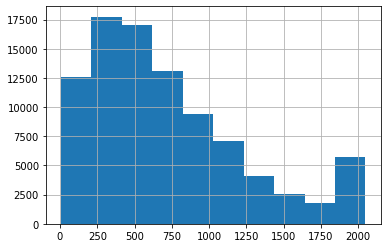

In [ ]:
descr_len = pd.Series(map(len, text_descr))
descr_len.sort_values().hist()
[print(f'{pct:4.0%}: {n:.0f}') for pct, n in descr_len.quantile([0, 0.5, 0.9, 0.95, 1]).items()]
pass
# Длина описания в символах

In [ ]:
print(*sorted(text_descr, key=len)[::-1][:3], sep='\n---\n')
# Пример самых длинных текстовых описаний

Диффузор ароматический с палочками, аромадиффузор
Ароматический диффузор - это самый простой, изящный, эффективный и долговременный способ ароматизации пространства. Наполните свой дом, офис или другое помещение приятным ароматом, создайте гармонию и расслабляющую обстановку, а также дополните свой интерьер актуальным элементом! Линейка ароматов: Мелодия розы - синергия любви и роскоши в одном флаконе. Чарующий пленительный аромат вызывает удовольствие и выпускает из сердца самые сокровенные чувства. Запах царицы цветов с аккордами жасмина, сандала и гвоздики настроит струны вашей души на приятную жизнеутверждающую волну. Нежная сирень - свежий весенний аромат, который превращает комнату в райский цветущий сад. Сиреневое облако, благоухающее бергамотом с нотами белого мускуса, гелиотропа, ванили, успокоит нервы, поможет обрести внутреннюю гармонию и восстановить силы. Золотистая мимоза - аромат, воплотивший в себе весеннее тепло и солнечный свет, цветочную сладость апельсина и фиалки с

## Tokenization

In [ ]:
%%time
tokens = tokenizer_fast(
    text_descr,
    return_token_type_ids=False,
    return_attention_mask=False,
    return_length=True,
)

CPU times: user 1min 17s, sys: 2.62 s, total: 1min 20s
Wall time: 59.4 s


In [ ]:
print(tokens.keys())
print('input_ids:', len(tokens['input_ids']))
print('input_ids[0]:', len(tokens['input_ids'][0]))
print('input_ids[1]:', len(tokens['input_ids'][1]))
print('length:', len(tokens['length']))

# tokens это словарь с ключами:
# input_ids: list of lists of ints - последовательности token ids разной длины
# length: list of ints - длина каждой последовательности

dict_keys(['input_ids', 'length'])
input_ids: 91120
input_ids[0]: 92
input_ids[1]: 60
length: 91120


  0%: 4
 50%: 141
 90%: 344
 95%: 428
100%: 1282


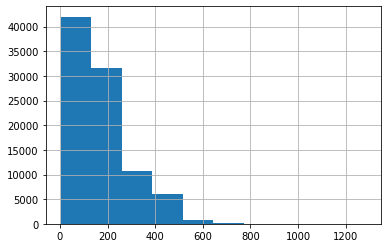

In [ ]:
tokens_len = pd.Series(tokens['length'])
tokens_len.sort_values().hist()
[print(f'{pct:4.0%}: {n:.0f}') for pct, n in tokens_len.quantile([0, 0.5, 0.9, 0.95, 1]).items()]
pass
# Длина описания в токенах

In [ ]:
# Приводим все последовательности токенов к одной длине
truncated_input_ids = truncate_and_pad_input_ids(
    tokens['input_ids'],
    tokenizer_fast.pad_token_id,
    INPUT_TOKENS_LIMIT)

print('Shape:', truncated_input_ids.shape)
print('Density: {:.2%}'.format((truncated_input_ids != 0).mean()))

Shape: (91120, 300)
Density: 52.33%


## Save to file

In [ ]:
# Метка класса / целевая переменная
labels = label_encoder.get_labels(df_train.category_id)
pd.Series(labels).value_counts(sort=False).sort_index().tail(33)

# Размеры классов

841    5
842    5
843    5
844    4
845    4
846    4
847    4
848    4
849    4
850    4
851    4
852    4
853    4
854    4
855    4
856    3
857    3
858    3
859    3
860    3
861    3
862    3
863    3
864    2
865    2
866    2
867    2
868    2
869    2
870    1
871    1
872    1
873    1
dtype: int64

In [ ]:
# Последние ~30 самых мелких категорий объединим в одну, иначе
# train_test_split(stratify=True) выдаст ошибку из-за классов с одним сэмплом
labels[labels >= 844] = 844

In [ ]:
# Оставим 10k сэмплов для проверки качества модели
train_idx, val_idx = train_test_split(range(len(labels)), test_size=10000,
    stratify=labels, random_state=SEED)

In [ ]:
%%time
np.savez_compressed('tokens_rubert_train',
                    input_ids=truncated_input_ids[train_idx],
                    product_ids=df_train.product_id.values[train_idx],
                    labels=labels[train_idx],
                )

CPU times: user 6.87 s, sys: 157 ms, total: 7.03 s
Wall time: 9.8 s


In [ ]:
%%time
np.savez_compressed('tokens_rubert_val',
                    input_ids=truncated_input_ids[val_idx],
                    product_ids=df_train.product_id.values[val_idx],
                    labels=labels[val_idx],
                )

CPU times: user 707 ms, sys: 10.4 ms, total: 717 ms
Wall time: 717 ms


In [ ]:
# Save to drive
!cp 'tokens_rubert_train.npz' {GDRIVE_DIR}
!cp 'tokens_rubert_val.npz' {GDRIVE_DIR}

## Test dataset

In [ ]:
# JSON → текстовое описание товара
text_descr = []

for row_id, row in tqdm(df_test.iterrows(), total=len(df_test)):
    fields_dict = json.loads(row.text_fields)
    text_descr.append(fields_to_text(fields_dict))

  0%|          | 0/16860 [00:00<?, ?it/s]

  0%: 19
 50%: 597
 90%: 1521
 95%: 2048
100%: 2048


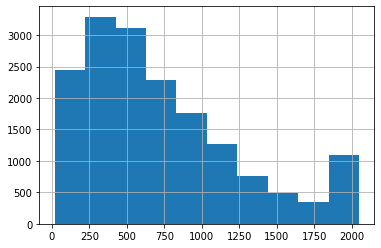

In [ ]:
descr_len = pd.Series(map(len, text_descr))
descr_len.sort_values().hist()
[print(f'{pct:4.0%}: {n:.0f}') for pct, n in descr_len.quantile([0, 0.5, 0.9, 0.95, 1]).items()]
pass
# Длина описания в символах

In [ ]:
print(*sorted(text_descr, key=len)[::-1][:3], sep='\n---\n')
# Пример самых длинных текстовых описаний

Пульт RDB-502 для цифровой приставки Rolsen
Данный пульт RDB-401, RDB-402, RDB-502, RDB-507, RDB-511 подходит к цифровым ресиверам приставкам DVB-T2 Rolsen: пульт для цифрового ресивера приставки DVB-T2 Rolsen RDB-101 пульт для цифрового ресивера приставки DVB-T2 Rolsen RDB-102 пульт для цифрового ресивера приставки DVB-T2 Rolsen RDB-103 пульт для цифрового ресивера приставки DVB-T2 Rolsen RDB-201 пульт для цифрового ресивера приставки DVB-T2 Rolsen RDB-202 пульт для цифрового ресивера приставки DVB-T2 Rolsen RDB-202 «R» пульт для цифрового ресивера приставки DVB-T2 Rolsen RDB-401 пульт для цифрового ресивера приставки DVB-T2 Rolsen RDB-402 пульт для цифрового ресивера приставки DVB-T2 Rolsen RDB-501N пульт для цифрового ресивера приставки DVB-T2 Rolsen RDB-502 пульт для цифрового ресивера приставки DVB-T2 Rolsen RDB-505 пульт для цифрового ресивера приставки DVB-T2 Rolsen RDB-505N пульт для цифрового ресивера приставки DVB-T2 Rolsen RDB-506N пульт для цифрового ресивера приставки DVB-

In [ ]:
%%time
tokens = tokenizer_fast(
    text_descr,
    return_token_type_ids=False,
    return_attention_mask=False,
    return_length=True,
)

CPU times: user 11.1 s, sys: 924 ms, total: 12.1 s
Wall time: 8.1 s


  0%: 6
 50%: 142
 90%: 351
 95%: 430
100%: 1334


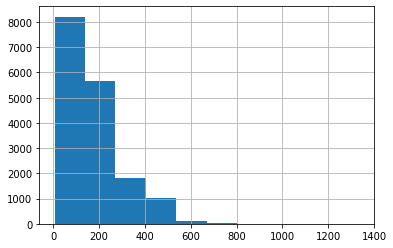

In [ ]:
tokens_len = pd.Series(tokens['length'])
tokens_len.sort_values().hist()
[print(f'{pct:4.0%}: {n:.0f}') for pct, n in tokens_len.quantile([0, 0.5, 0.9, 0.95, 1]).items()]
pass
# Длина описания в токенах

In [ ]:
# Приводим все последовательности токенов к одной длине
truncated_input_ids = truncate_and_pad_input_ids(
    tokens['input_ids'],
    tokenizer_fast.pad_token_id,
    INPUT_TOKENS_LIMIT)

print('Shape:', truncated_input_ids.shape)
print('Density: {:.2%}'.format((truncated_input_ids != 0).mean()))

Shape: (16860, 300)
Density: 52.73%


In [ ]:
%%time
np.savez_compressed('tokens_rubert_test',
                    input_ids=truncated_input_ids,
                    product_ids=df_test.product_id.values,
                )

CPU times: user 1.01 s, sys: 5.22 ms, total: 1.02 s
Wall time: 1.02 s


In [ ]:
!cp tokens_rubert_test.npz {GDRIVE_DIR}